In [161]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from prophet import Prophet
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Bidirectional
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, ParameterGrid
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [162]:
df = pd.read_excel("Data Penghasilan Tetap.xlsx")
df.drop(columns="Saldo Akhir", inplace = True)
df.head(10)

,Tanggal,Saldo Awal,Pemasukan,Pengeluaran
0,2024-01-01,1500000,0,50000
1,2024-01-02,1450000,0,30000
2,2024-01-03,1420000,0,25000
3,2024-01-04,1395000,0,35000
4,2024-01-05,1360000,0,40000
5,2024-01-06,1320000,0,60000
6,2024-01-07,1260000,0,20000
7,2024-01-08,1240000,1500000,100000
8,2024-01-09,2640000,0,30000
9,2024-01-10,2610000,0,35000


In [163]:
len(df)

192

In [164]:
df.isna().sum()

Tanggal        0
Saldo Awal     0
Pemasukan      0
Pengeluaran    0
dtype: int64

In [165]:
df_masuk = df[["Tanggal","Pemasukan"]]
df_luar = df[["Tanggal","Pengeluaran"]]

In [166]:
df_masuk['ds'] = pd.to_datetime(df_masuk['Tanggal'])
df_masuk['y'] = df_masuk['Pemasukan']

In [167]:
df_masuk = df_masuk.drop(columns=["Tanggal", "Pemasukan"])
df_masuk.columns

Index(['ds', 'y'], dtype='object')

In [168]:
df_masuk_test = df_masuk.tail(30)
df_masuk_train = df_masuk.head(162)

In [169]:
df_luar['ds'] = pd.to_datetime(df_luar['Tanggal'])
df_luar['y'] = df_luar['Pengeluaran']

In [170]:
df_luar = df_luar.drop(columns=["Tanggal", "Pengeluaran"])
df_luar.columns

Index(['ds', 'y'], dtype='object')

In [171]:
df_luar_test = df_luar.tail(30)
df_luar_train = df_luar.head(162)

<Axes: >

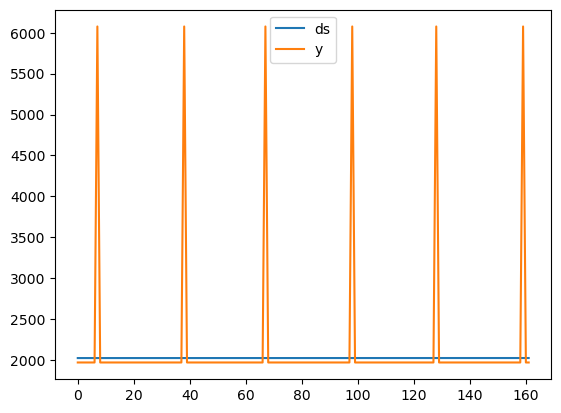

In [172]:
df_masuk_train.plot()

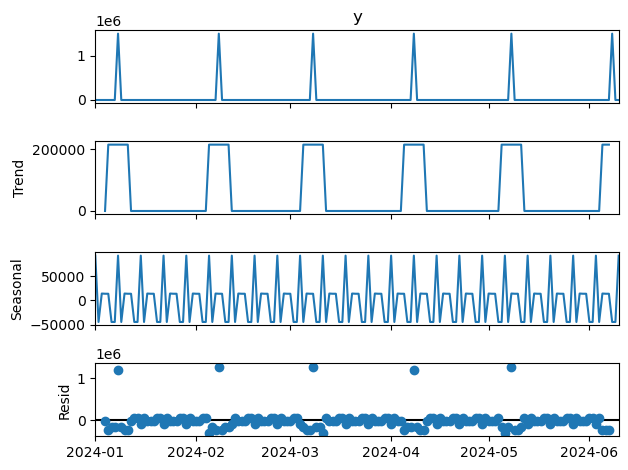

In [173]:
temp1 = df_masuk_train
temp1.set_index("ds", inplace=True)
result = seasonal_decompose(temp1["y"])
result.plot();

<Axes: >

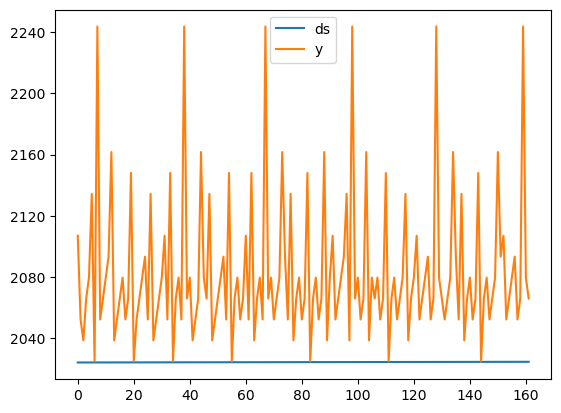

In [174]:
df_luar_train.plot()

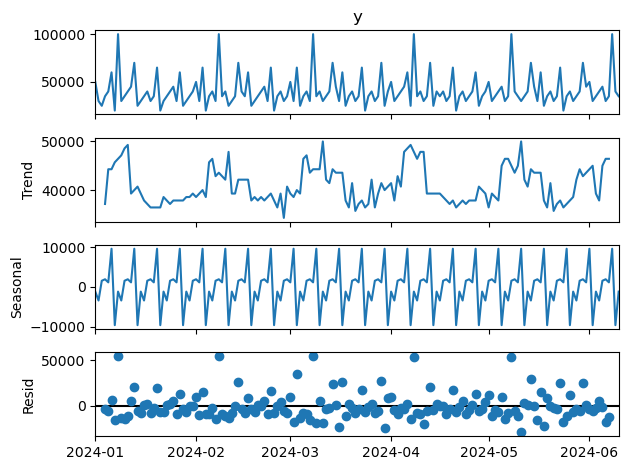

In [175]:
temp2 = df_luar_train
temp2.set_index("ds", inplace=True)
result = seasonal_decompose(temp2["y"])
result.plot();

In [176]:
df_masuk_train.reset_index(inplace=True)
df_luar_train.reset_index(inplace=True)
print(df_masuk_train.columns)
print(df_masuk_test.columns)

Index(['ds', 'y'], dtype='object')
Index(['ds', 'y'], dtype='object')


In [177]:
# Total Uang yang akan diprediksi 4.090.000
uang_akhir = 4090000
df.tail()

,Tanggal,Saldo Awal,Pemasukan,Pengeluaran
187,2024-07-06,2850000,0,60000
188,2024-07-07,2790000,0,25000
189,2024-07-08,2765000,1500000,100000
190,2024-07-09,4165000,0,35000
191,2024-07-10,4130000,0,40000


In [178]:
saldo_awal = 3855000
df[155:165]

,Tanggal,Saldo Awal,Pemasukan,Pengeluaran
155,2024-06-04,2680000,0,40000
156,2024-06-05,2640000,0,45000
157,2024-06-06,2595000,0,30000
158,2024-06-07,2565000,0,35000
159,2024-06-08,2530000,1500000,100000
160,2024-06-09,3930000,0,40000
161,2024-06-10,3890000,0,35000
162,2024-06-11,3855000,0,30000
163,2024-06-12,3825000,0,35000
164,2024-06-13,3790000,0,70000


In [179]:
nama_metode = []
saldo_akhir = []
error = []

## Using Prophet

In [181]:
def prophet_forecast(train, test, params):
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        seasonality_mode=params['seasonality_mode']
    )
    model.fit(train)
    forecast = model.predict(test[['ds']])
    return forecast['yhat']

# Hyperparameter yang akan dituning
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

In [182]:
# Grid Search Manual
grid = ParameterGrid(param_grid)

# Data splitting (Contoh, data di-split 80% train dan 20% test)
train_size = int(len(df_masuk) * 0.8)
train = df_masuk[:train_size]
test = df_masuk[train_size:]

best_params = None
best_mae = float('inf')

# Looping melalui grid search
for params in grid:
    forecast = prophet_forecast(train, test, params)
    mae = mean_absolute_error(test['y'], forecast)
    print(f"Params: {params}, MAE: {mae}")

    # Jika hasil MAE lebih baik, simpan parameter terbaik
    if mae < best_mae:
        best_mae = mae
        best_params = params

print(f"Best Parameters: {best_params}, Best MAE: {best_mae}")

19:56:34 - cmdstanpy - INFO - Chain [1] start processing
19:56:35 - cmdstanpy - INFO - Chain [1] done processing
19:56:35 - cmdstanpy - INFO - Chain [1] start processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}, MAE: 134214.69343819056


19:56:35 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}, MAE: 133470.7751311133


19:56:35 - cmdstanpy - INFO - Chain [1] start processing
19:56:36 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}, MAE: 133456.55860494496


19:56:36 - cmdstanpy - INFO - Chain [1] start processing
19:56:37 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}, MAE: 134587.7224770133


19:56:37 - cmdstanpy - INFO - Chain [1] start processing
19:56:38 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}, MAE: 134602.48695891313


19:56:38 - cmdstanpy - INFO - Chain [1] start processing
19:56:38 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}, MAE: 134601.22661504155


19:56:39 - cmdstanpy - INFO - Chain [1] start processing
19:56:39 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}, MAE: 117398.91862825654


19:56:40 - cmdstanpy - INFO - Chain [1] start processing
19:56:40 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}, MAE: 118909.53478203752


19:56:41 - cmdstanpy - INFO - Chain [1] start processing
19:56:41 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}, MAE: 119351.91844304513


19:56:41 - cmdstanpy - INFO - Chain [1] start processing
19:56:42 - cmdstanpy - INFO - Chain [1] done processing
19:56:42 - cmdstanpy - INFO - Chain [1] start processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}, MAE: 102688.61473298275


19:56:42 - cmdstanpy - INFO - Chain [1] done processing
19:56:43 - cmdstanpy - INFO - Chain [1] start processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}, MAE: 99669.29785011867


19:56:43 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}, MAE: 103644.68566581255


19:56:43 - cmdstanpy - INFO - Chain [1] start processing
19:56:43 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}, MAE: 116346.95113325823


19:56:44 - cmdstanpy - INFO - Chain [1] start processing
19:56:44 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}, MAE: 117617.15788640924


19:56:44 - cmdstanpy - INFO - Chain [1] start processing
19:56:45 - cmdstanpy - INFO - Chain [1] done processing
19:56:45 - cmdstanpy - INFO - Chain [1] start processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}, MAE: 117555.82538143116


19:56:45 - cmdstanpy - INFO - Chain [1] done processing
19:56:45 - cmdstanpy - INFO - Chain [1] start processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}, MAE: 104281.8389998005


19:56:46 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}, MAE: 121549.48151842512


19:56:46 - cmdstanpy - INFO - Chain [1] start processing
19:56:47 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}, MAE: 80432.05135300099
Best Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}, Best MAE: 80432.05135300099


In [183]:
best_params = {
    'changepoint_prior_scale': 0.5,
    'seasonality_prior_scale': 10.0,
    'seasonality_mode': 'multiplicative'
}

# Buat model Prophet dengan parameter terbaik
best_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    seasonality_mode=best_params['seasonality_mode']
)

# Fit model pada seluruh dataset training
best_model.fit(df_masuk_train)

# Prediksi pada data baru atau test set
future = best_model.make_future_dataframe(periods=30)  # Menentukan berapa banyak data yang akan diprediksi
forecast = best_model.predict(future)

# Tampilkan hasil prediksi
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

19:56:47 - cmdstanpy - INFO - Chain [1] start processing
19:56:47 - cmdstanpy - INFO - Chain [1] done processing


            ds           yhat     yhat_lower     yhat_upper
0   2024-01-01  222954.811493 -135493.885626  582364.704693
1   2024-01-02    -643.252458 -360065.249045  372812.712132
2   2024-01-03  114393.589010 -257990.318904  468186.228682
3   2024-01-04   99655.570734 -242971.613677  475364.431210
4   2024-01-05   96736.600234 -262609.938792  464451.098130
..         ...            ...            ...            ...
187 2024-07-06   95367.404985 -245643.014161  437689.372819
188 2024-07-07   -1241.868169 -351878.308026  370229.742794
189 2024-07-08  156527.751185 -210042.855237  530028.337899
190 2024-07-09    -461.283473 -336299.650851  339633.994743
191 2024-07-10   83818.572980 -269841.789190  451636.558533

[192 rows x 4 columns]


In [184]:
df_masuk_test["yhat"] = forecast["yhat"].tail(30)
df_masuk_test.head()

,ds,y,yhat
162,2024-06-11,0,-420.804498
163,2024-06-12,0,76486.227714
164,2024-06-13,0,68125.634536
165,2024-06-14,0,67635.977671
166,2024-06-15,0,89031.255212


In [185]:
df_masuk_test.set_index("ds", inplace = True)

In [186]:
df_masuk_test

,y,yhat
ds,,
2024-06-11,0,-420.804498
2024-06-12,0,76486.227714
2024-06-13,0,68125.634536
2024-06-14,0,67635.977671
2024-06-15,0,89031.255212
2024-06-16,0,-1159.619454
2024-06-17,0,146193.537226
2024-06-18,0,-430.924242
2024-06-19,0,78319.314030


<Axes: xlabel='ds'>

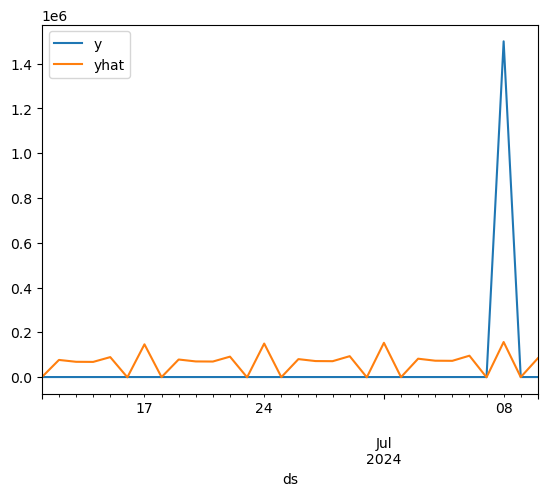

In [187]:
df_masuk_test.plot()

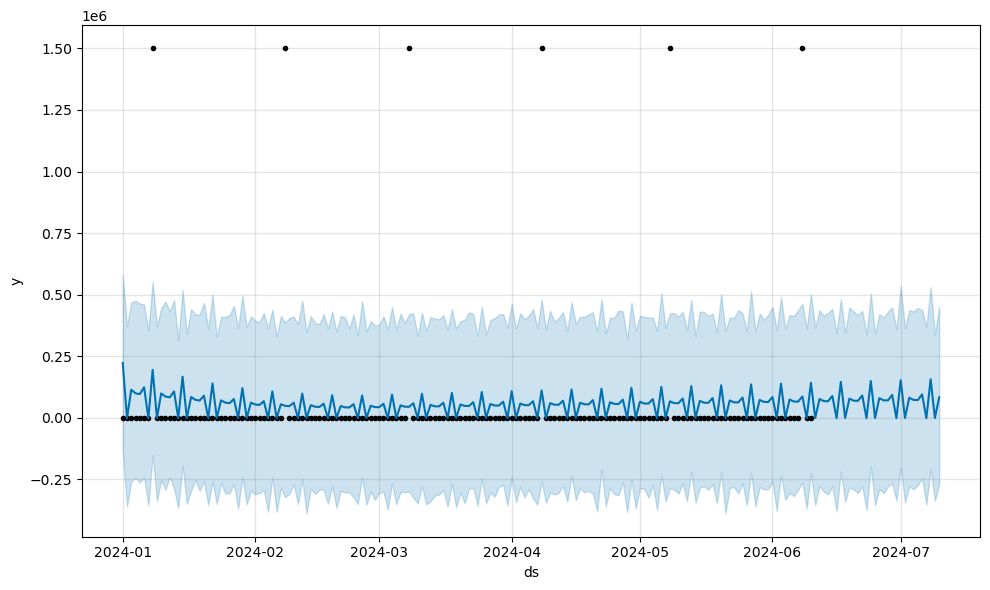

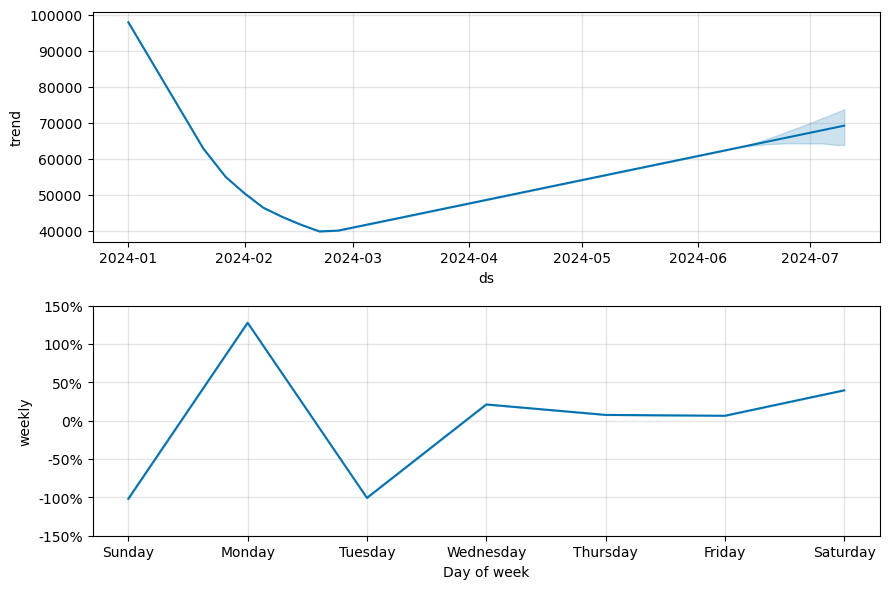

In [188]:
best_model.plot(forecast)
plt.show()

best_model.plot_components(forecast)
plt.show()

In [189]:
def prophet_forecast(train, test, params):
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        seasonality_mode=params['seasonality_mode']
    )
    model.fit(train)
    forecast = model.predict(test[['ds']])
    return forecast['yhat']

# Hyperparameter yang akan dituning
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

In [190]:
# Grid Search Manual
grid = ParameterGrid(param_grid)

# Data splitting (Contoh, data di-split 80% train dan 20% test)
train_size = int(len(df_luar) * 0.8)
train = df_luar[:train_size]
test = df_luar[train_size:]

best_params = None
best_mae = float('inf')

# Looping melalui grid search
for params in grid:
    forecast = prophet_forecast(train, test, params)
    mae = mean_absolute_error(test['y'], forecast)
    print(f"Params: {params}, MAE: {mae}")

    # Jika hasil MAE lebih baik, simpan parameter terbaik
    if mae < best_mae:
        best_mae = mae
        best_params = params

print(f"Best Parameters: {best_params}, Best MAE: {best_mae}")

19:56:49 - cmdstanpy - INFO - Chain [1] start processing
19:56:50 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}, MAE: 11786.70320637951


19:56:50 - cmdstanpy - INFO - Chain [1] start processing
19:56:50 - cmdstanpy - INFO - Chain [1] done processing
19:56:51 - cmdstanpy - INFO - Chain [1] start processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}, MAE: 11845.601401431391


19:56:51 - cmdstanpy - INFO - Chain [1] done processing
19:56:51 - cmdstanpy - INFO - Chain [1] start processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}, MAE: 11846.01772405861


19:56:52 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}, MAE: 11426.024805445373


19:56:52 - cmdstanpy - INFO - Chain [1] start processing
19:56:52 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}, MAE: 11487.245101912


19:56:53 - cmdstanpy - INFO - Chain [1] start processing
19:56:53 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}, MAE: 11493.359352911208


19:56:54 - cmdstanpy - INFO - Chain [1] start processing
19:56:54 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}, MAE: 12014.360011901656


19:56:54 - cmdstanpy - INFO - Chain [1] start processing
19:56:55 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}, MAE: 12075.795287268293


19:56:55 - cmdstanpy - INFO - Chain [1] start processing
19:56:55 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}, MAE: 12094.295282694253


19:56:56 - cmdstanpy - INFO - Chain [1] start processing
19:56:56 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}, MAE: 11866.494081439561


19:56:57 - cmdstanpy - INFO - Chain [1] start processing
19:56:57 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}, MAE: 11924.304178422903


19:56:57 - cmdstanpy - INFO - Chain [1] start processing
19:56:58 - cmdstanpy - INFO - Chain [1] done processing
19:56:58 - cmdstanpy - INFO - Chain [1] start processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}, MAE: 11931.98588066807


19:56:58 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}, MAE: 12177.245686773274


19:56:59 - cmdstanpy - INFO - Chain [1] start processing
19:56:59 - cmdstanpy - INFO - Chain [1] done processing
19:56:59 - cmdstanpy - INFO - Chain [1] start processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}, MAE: 12218.1128891227


19:56:59 - cmdstanpy - INFO - Chain [1] done processing
19:57:00 - cmdstanpy - INFO - Chain [1] start processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}, MAE: 12190.44675027826


19:57:00 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}, MAE: 11953.688887426859


19:57:00 - cmdstanpy - INFO - Chain [1] start processing
19:57:01 - cmdstanpy - INFO - Chain [1] done processing
19:57:01 - cmdstanpy - INFO - Chain [1] start processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}, MAE: 12020.997098374111


19:57:01 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}, MAE: 12006.626257815613
Best Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}, Best MAE: 11426.024805445373


In [191]:
best_params = {
    'changepoint_prior_scale': 0.01,
    'seasonality_prior_scale': 0.1,
    'seasonality_mode': 'multiplicative'
}

# Buat model Prophet dengan parameter terbaik
best_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    seasonality_mode=best_params['seasonality_mode']
)

# Fit model pada seluruh dataset training
best_model.fit(df_luar_train)

# Prediksi pada data baru atau test set
future = best_model.make_future_dataframe(periods=30)  # Menentukan berapa banyak data yang akan diprediksi
forecast = best_model.predict(future)

# Tampilkan hasil prediksi
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

19:57:02 - cmdstanpy - INFO - Chain [1] start processing
19:57:02 - cmdstanpy - INFO - Chain [1] done processing


            ds          yhat    yhat_lower    yhat_upper
0   2024-01-01  41198.540236  19768.770079  61816.607249
1   2024-01-02  38290.116615  18105.793761  58649.777734
2   2024-01-03  42493.840235  21920.789639  61502.560218
3   2024-01-04  43796.262443  23872.822347  64638.794598
4   2024-01-05  42990.822662  22699.361373  63196.547762
..         ...           ...           ...           ...
187 2024-07-06  48989.684919  27422.043127  67780.878768
188 2024-07-07  31409.100358  10210.368086  52864.436630
189 2024-07-08  38397.558656  17160.842803  59148.104671
190 2024-07-09  35685.934717  14972.502589  57304.591046
191 2024-07-10  39602.715258  18902.106381  58996.376516

[192 rows x 4 columns]


In [192]:
df_luar_test["yhat"] = forecast["yhat"].tail(30)
df_luar_test.head()

,ds,y,yhat
162,2024-06-11,30000,36071.739058
163,2024-06-12,35000,40031.029697
164,2024-06-13,70000,41257.053863
165,2024-06-14,25000,40497.414111
166,2024-06-15,40000,49386.449756


In [193]:
df_luar_test.set_index("ds", inplace = True)

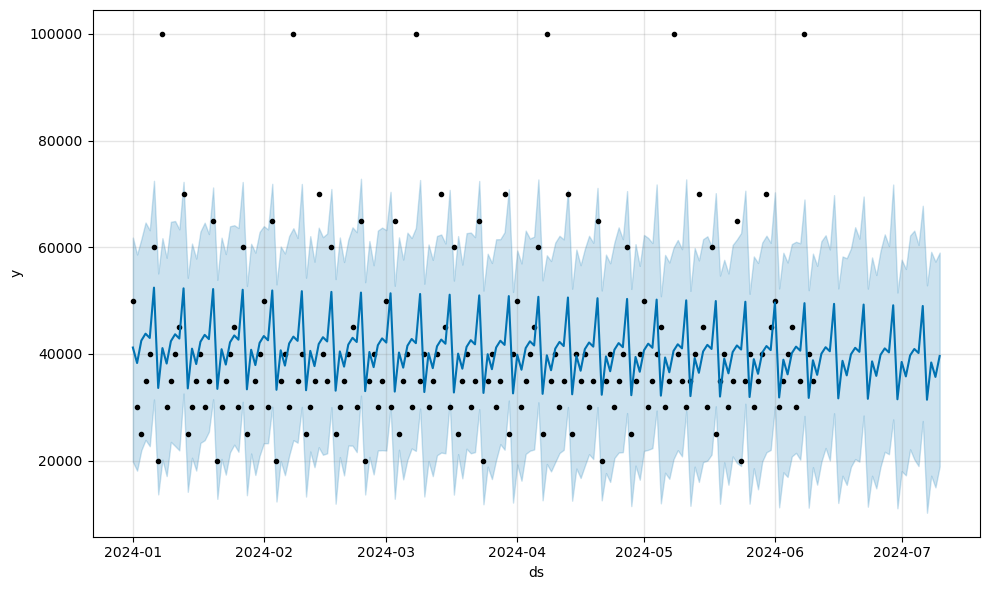

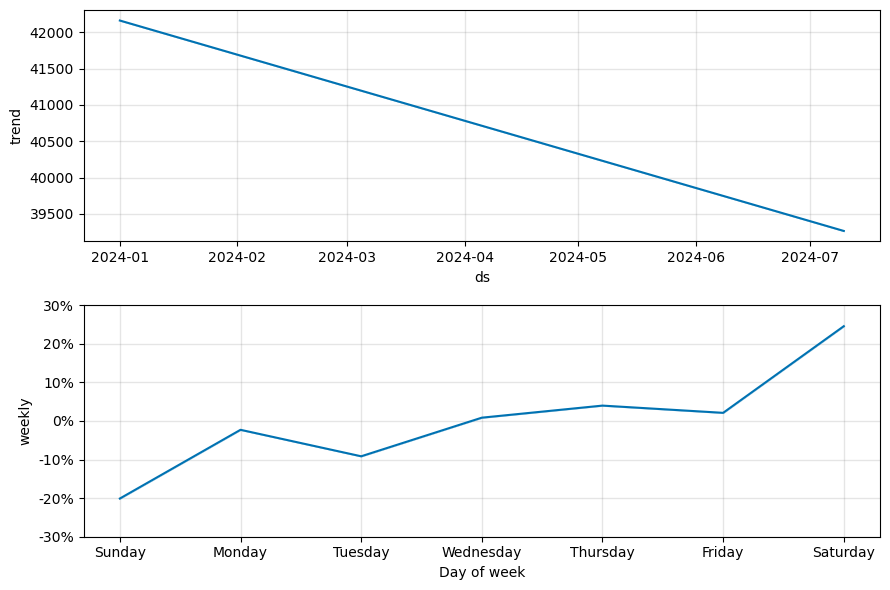

In [194]:
best_model.plot(forecast)
plt.show()

best_model.plot_components(forecast)
plt.show()

317903311.61725384


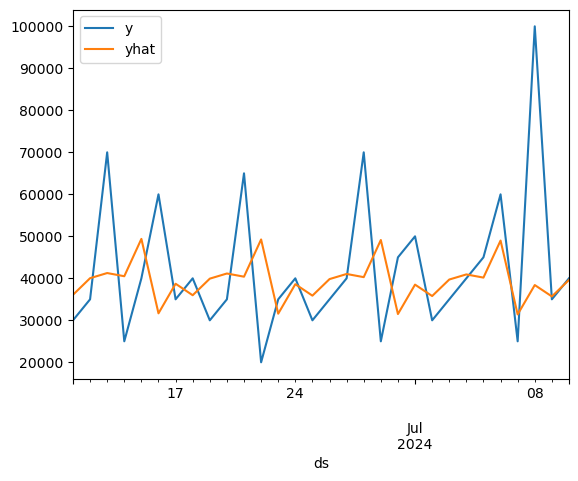

In [195]:
df_luar_test.plot()
print(mean_squared_error(df_luar_test["y"], df_luar_test["yhat"]))

In [196]:
saldo_awal = 3855000
saldo_akhir_test = 4090000

temp1 = np.array(df_masuk_test["yhat"])
temp2 = np.array(df_luar_test["yhat"])

print(f"Saldo Awal anda adalah {saldo_awal}, dengan saldo akhir (true) adalah {saldo_akhir_test}")
for i in range(len(temp1)):
    saldo_awal = saldo_awal + temp1[i] - temp2[i]

print(f"saldo akhir prediksi anda adalah {round(saldo_awal)}, dengan error sebesar {round(abs(saldo_akhir_test - saldo_awal))}")

Saldo Awal anda adalah 3855000, dengan saldo akhir (true) adalah 4090000
saldo akhir prediksi anda adalah 4604169, dengan error sebesar 514169


In [197]:
nama_metode.append("prophet")
saldo_akhir.append(round(saldo_awal))
error.append(round(abs(saldo_akhir_test - saldo_awal)))

In [198]:
print(df_masuk_train.columns)
print(df_masuk_test.columns)
print(df_luar_train.columns)
print(df_luar_test.columns)

Index(['ds', 'y'], dtype='object')
Index(['y', 'yhat'], dtype='object')
Index(['ds', 'y'], dtype='object')
Index(['y', 'yhat'], dtype='object')


In [199]:
df_masuk_train.set_index("ds", inplace=True)
df_luar_train.set_index("ds", inplace=True)

## Using LSTM

### Pemasukan

In [202]:
df_masuk_test.drop(columns="yhat", inplace = True)
sc = MinMaxScaler()
train_transform = sc.fit_transform(df_masuk_train)
test_tranform = sc.transform(df_masuk_test)

In [203]:
df_masuk_train

,y
ds,
2024-01-01,0
2024-01-02,0
2024-01-03,0
2024-01-04,0
2024-01-05,0
...,...
2024-06-06,0
2024-06-07,0
2024-06-08,1500000


In [204]:
n_input = 35
n_features = 1

generator = TimeseriesGenerator(train_transform, train_transform, length = n_input, batch_size = 1)

In [205]:
rnn = Sequential()

rnn.add(LSTM(units = 10, activation = "relu", return_sequences = True, input_shape = (n_input, n_features)))

rnn.add(LSTM(units = 10, activation = "relu"))

rnn.add(Dense(units = 1))

rnn.compile(optimizer = "adam", loss = "mse")

In [206]:
rnn.fit(generator, epochs=100)

Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.0218
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0436
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0162
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0257
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0412
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0507
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0561
Epoch 8/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0689
Epoch 9/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0444
Epoch 10/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0491
Epoch 11/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0742
Epoch 12/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0172
Epoch 13/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0221
Epoch 14/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0417
Epoch 15/100
127/127 ━━━━━━━

In [207]:
test_prediction = []

first_eval_batch = train_transform[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(df_masuk_test)):
    current_pred = rnn.predict(current_batch)[0]
    test_prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━

In [208]:
hasil_akhir = []

for i in range(len(test_prediction)):
    hasil_akhir.append(test_prediction[i][0])

hasil_akhir = np.array(hasil_akhir)
hasil_akhir = hasil_akhir.reshape(-1,1)

hasil_akhir = sc.inverse_transform(hasil_akhir)
hasil_akhir = hasil_akhir.reshape(-1)

In [209]:
df_masuk_test["yhat"] = hasil_akhir

<Axes: xlabel='ds'>

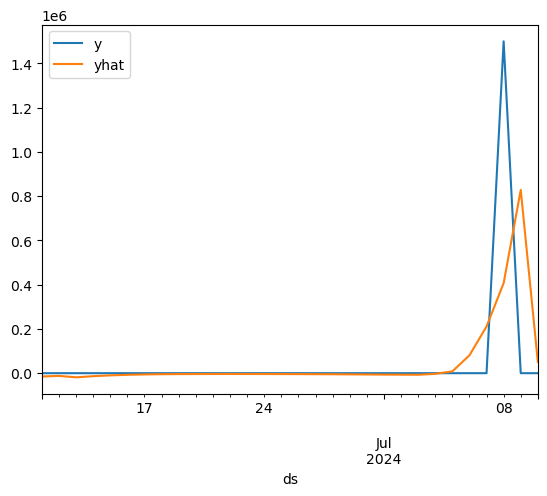

In [210]:
df_masuk_test.plot()

### Pengeluaran

In [212]:
df_luar_test.drop(columns="yhat", inplace = True)
sc = MinMaxScaler()
train_transform = sc.fit_transform(df_luar_train)
test_tranform = sc.transform(df_luar_test)

In [213]:
n_input = 35
n_features = 1

generator = TimeseriesGenerator(train_transform, train_transform, length = n_input, batch_size = 1)

In [214]:
rnn = Sequential()

rnn.add(LSTM(units = 75, activation = "relu", return_sequences = True, input_shape = (n_input, n_features)))

rnn.add(LSTM(units = 75, activation = "relu"))

rnn.add(Dense(units = 1))

rnn.compile(optimizer = "adam", loss = "mse")

In [215]:
rnn.fit(generator, epochs=5)

Epoch 1/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.0620
Epoch 2/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0518
Epoch 3/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0354
Epoch 4/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0469
Epoch 5/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0320


In [216]:
test_prediction = []

first_eval_batch = train_transform[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(df_masuk_test)):
    current_pred = rnn.predict(current_batch)[0]
    test_prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━

In [217]:
hasil_akhir = []

for i in range(len(test_prediction)):
    hasil_akhir.append(test_prediction[i][0])

hasil_akhir = np.array(hasil_akhir)
hasil_akhir = hasil_akhir.reshape(-1,1)

hasil_akhir = sc.inverse_transform(hasil_akhir)
hasil_akhir = hasil_akhir.reshape(-1)

In [218]:
print(hasil_akhir)

[43051.426 43145.973 43195.887 43214.92  43212.25  43195.8   43171.305
 43142.977 43113.246 43084.86  43058.527 43034.062 43012.723 42993.645
 42976.9   42962.492 42949.914 42938.746 42929.8   42921.875 42915.01
 42909.277 42904.254 42899.875 42895.66  42892.496 42889.72  42887.65
 42885.734 42883.996]


In [219]:
df_luar_test["yhat"] = hasil_akhir

In [220]:
rmse = np.sqrt(np.mean((df_luar_test["yhat"] - df_luar_test["y"])**2))
print(f'RMSE: {rmse}')

RMSE: 16846.93504289013


<Axes: xlabel='ds'>

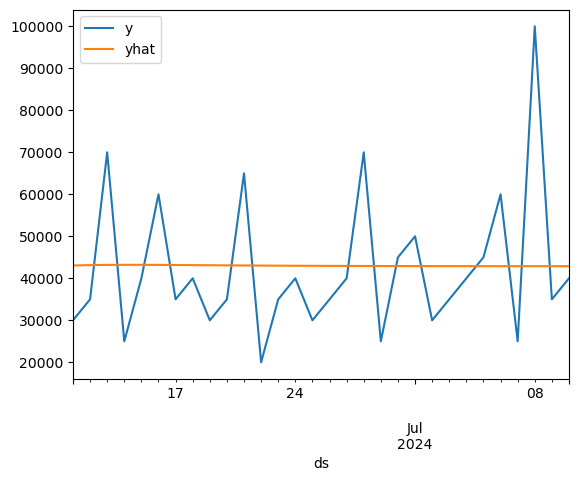

In [221]:
df_luar_test.plot()

In [222]:
saldo_awal = 3855000
saldo_akhir_test = 4090000

temp1 = np.array(df_masuk_test["yhat"])
temp2 = np.array(df_luar_test["yhat"])

print(f"Saldo Awal anda adalah {saldo_awal}, dengan saldo akhir (true) adalah {saldo_akhir_test}")
for i in range(len(temp1)):
    saldo_awal = saldo_awal + temp1[i] - temp2[i]

print(f"saldo akhir prediksi anda adalah {round(saldo_awal)}, dengan error sebesar {round(abs(saldo_akhir_test - saldo_awal))}")

Saldo Awal anda adalah 3855000, dengan saldo akhir (true) adalah 4090000
saldo akhir prediksi anda adalah 3989299, dengan error sebesar 100701


In [223]:
nama_metode.append("LSTM")
saldo_akhir.append(round(saldo_awal))
error.append(round(abs(saldo_akhir_test - saldo_awal)))

## Random Forest

### Pemasukan

108164316666.66667


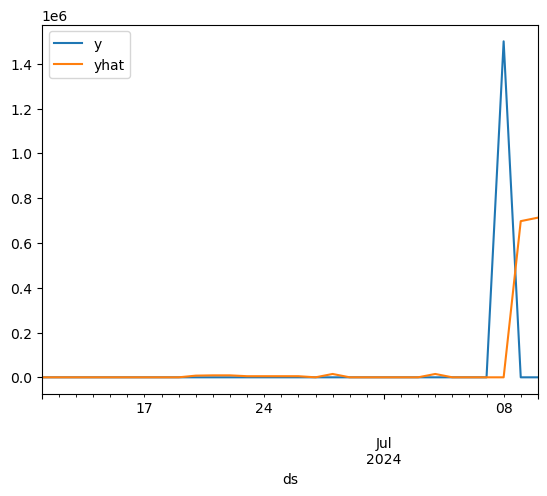

In [226]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Assume df_masuk_train is your DataFrame
# df_masuk_train = pd.DataFrame({'y': np.random.rand(170)})  # Example DataFrame

# Set parameters
timesteps = 35  # number of input steps
n_forecast_days = 30  # number of days to predict
data_length_train = len(df_masuk_train)  # length of training signal

# Create dataset for training
X_train = []
y_train = []

# Create input-output sequence for training
for i in range(data_length_train - timesteps - n_forecast_days + 1):
    X_train.append(df_masuk_train['y'].iloc[i:i + timesteps].values)
    y_train.append(df_masuk_train['y'].iloc[i + timesteps:i + timesteps + n_forecast_days].values)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Train Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions for 30 days ahead
last_input = df_masuk_train['y'].iloc[-timesteps:].values.reshape(1, -1)
y_pred = []

for _ in range(n_forecast_days):
    pred = model.predict(last_input)[0]  # predict next day
    y_pred.append(pred[0])  # store prediction
    last_input = np.roll(last_input, -1)  # shift input
    last_input[0, -1] = pred[0]  # insert prediction into input

# Display results
df_masuk_test['yhat'] = pred

df_masuk_test.plot()
print(mean_squared_error(df_masuk_test["y"], df_masuk_test["yhat"]))


### Pengeluaran

283330500.0


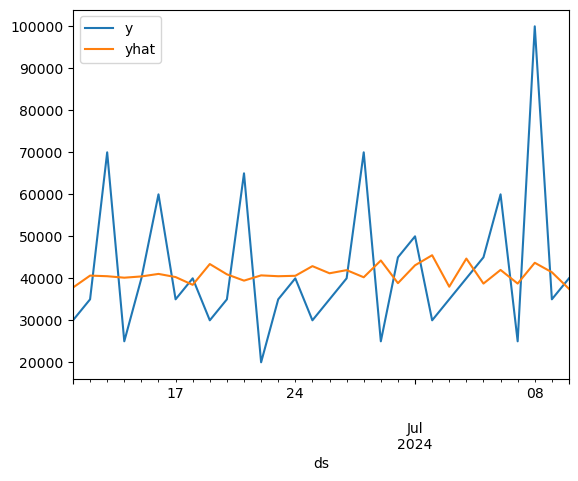

In [228]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Assume df_luar_train is your DataFrame
# df_luar_train = pd.DataFrame({'y': np.random.rand(170)})  # Example DataFrame

# Set parameters
timesteps = 14  # number of input steps
n_forecast_days = 30  # number of days to predict
data_length_train = len(df_luar_train)  # length of training signal

# Create dataset for training
X_train = []
y_train = []

# Create input-output sequence for training
for i in range(data_length_train - timesteps - n_forecast_days + 1):
    X_train.append(df_luar_train['y'].iloc[i:i + timesteps].values)
    y_train.append(df_luar_train['y'].iloc[i + timesteps:i + timesteps + n_forecast_days].values)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Train Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions for 30 days ahead
last_input = df_luar_train['y'].iloc[-timesteps:].values.reshape(1, -1)
y_pred = []

for _ in range(n_forecast_days):
    pred = model.predict(last_input)[0]  # predict next day
    y_pred.append(pred[0])  # store prediction
    last_input = np.roll(last_input, -1)  # shift input
    last_input[0, -1] = pred[0]  # insert prediction into input

# Display results
df_luar_test['yhat'] = pred

df_luar_test.plot()
print(mean_squared_error(df_luar_test["y"], df_luar_test["yhat"]))

In [229]:
saldo_awal = 3855000
saldo_akhir_test = 4090000

temp1 = np.array(df_masuk_test["yhat"])
temp2 = np.array(df_luar_test["yhat"])

print(f"Saldo Awal anda adalah {saldo_awal}, dengan saldo akhir (true) adalah {saldo_akhir_test}")
for i in range(len(temp1)):
    saldo_awal = saldo_awal + temp1[i] - temp2[i]

print(f"saldo akhir prediksi anda adalah {saldo_awal}, dengan error sebesar {abs(saldo_akhir_test - saldo_awal)}")

Saldo Awal anda adalah 3855000, dengan saldo akhir (true) adalah 4090000
saldo akhir prediksi anda adalah 4112200.0, dengan error sebesar 22200.0


In [230]:
nama_metode.append("Random Forest")
saldo_akhir.append(round(saldo_awal))
error.append(round(abs(saldo_akhir_test - saldo_awal)))

## SVR

### Pemasukan

Best parameters: {'C': 100, 'epsilon': 0.1, 'kernel': 'rbf'}


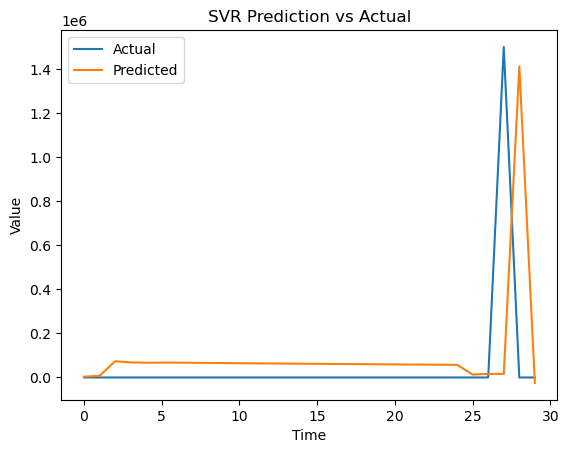

Mean Squared Error: 142953862722.8942


In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Assume df_masuk_train is your DataFrame
# df_masuk_train = pd.DataFrame({'y': np.random.rand(170)})  # Example DataFrame

# Set parameters
timesteps = 35  # number of input steps
n_forecast_days = 30  # number of days to predict
data_length_train = len(df_masuk_train)  # length of training signal

# Create dataset for training
X_train = []
y_train = []

# Create input-output sequence for training
for i in range(data_length_train - timesteps - n_forecast_days + 1):
    X_train.append(df_masuk_train['y'].iloc[i:i + timesteps].values)
    y_train.append(df_masuk_train['y'].iloc[i + timesteps])  # Changed this line

X_train = np.array(X_train)
y_train = np.array(y_train)

# Scale the features
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

# Define parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2],
    'kernel': ['rbf', 'linear']
}

# Create SVR model
svr = SVR()

# Perform GridSearchCV
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_scaled)

# Get best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters:", best_params)

# Make predictions for 30 days ahead
last_input = df_masuk_train['y'].iloc[-timesteps:].values.reshape(1, -1)
last_input_scaled = scaler_X.transform(last_input)
y_pred = []

for _ in range(n_forecast_days):
    pred_scaled = best_model.predict(last_input_scaled).reshape(1, -1)  # predict next day
    pred = scaler_y.inverse_transform(pred_scaled)  # scale back to original range
    y_pred.append(pred[0, 0])  # store prediction
    last_input_scaled = np.roll(last_input_scaled, -1)  # shift input
    last_input_scaled[0, -1] = pred_scaled[0, 0]  # insert prediction into input

# Display results
df_masuk_test = pd.DataFrame({'y': df_masuk_train['y'].iloc[-n_forecast_days:].values})
df_masuk_test['yhat'] = y_pred
df_masuk_test.plot()
plt.title('SVR Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Actual', 'Predicted'])
plt.show()

# Calculate and print MSE
mse = mean_squared_error(df_masuk_test['y'], df_masuk_test['yhat'])
print(f"Mean Squared Error: {mse}")

### Pengeluaran

Best parameters: {'C': 10, 'epsilon': 0.01, 'kernel': 'rbf'}


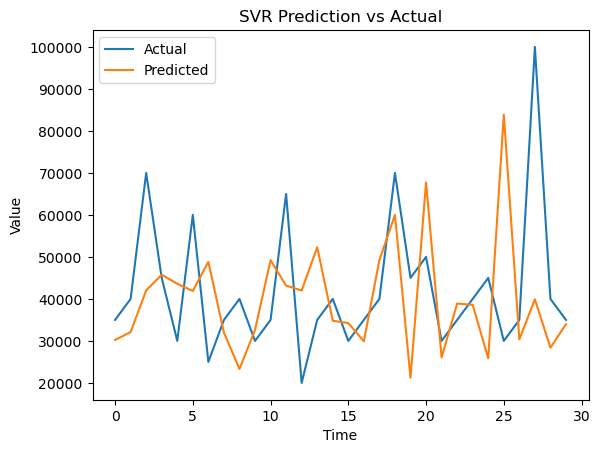

Mean Squared Error: 397098637.55161357


In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Assume df_luar_train is your DataFrame
# df_luar_train = pd.DataFrame({'y': np.random.rand(170)})  # Example DataFrame

# Set parameters
timesteps = 14  # number of input steps
n_forecast_days = 30  # number of days to predict
data_length_train = len(df_luar_train)  # length of training signal

# Create dataset for training
X_train = []
y_train = []

# Create input-output sequence for training
for i in range(data_length_train - timesteps - n_forecast_days + 1):
    X_train.append(df_luar_train['y'].iloc[i:i + timesteps].values)
    y_train.append(df_luar_train['y'].iloc[i + timesteps])  # Changed this line

X_train = np.array(X_train)
y_train = np.array(y_train)

# Scale the features
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

# Define parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2],
    'kernel': ['rbf', 'linear']
}

# Create SVR model
svr = SVR()

# Perform GridSearchCV
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_scaled)

# Get best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters:", best_params)

# Make predictions for 30 days ahead
last_input = df_luar_train['y'].iloc[-timesteps:].values.reshape(1, -1)
last_input_scaled = scaler_X.transform(last_input)
y_pred = []

for _ in range(n_forecast_days):
    pred_scaled = best_model.predict(last_input_scaled).reshape(1, -1)  # predict next day
    pred = scaler_y.inverse_transform(pred_scaled)  # scale back to original range
    y_pred.append(pred[0, 0])  # store prediction
    last_input_scaled = np.roll(last_input_scaled, -1)  # shift input
    last_input_scaled[0, -1] = pred_scaled[0, 0]  # insert prediction into input

# Display results
df_luar_test = pd.DataFrame({'y': df_luar_train['y'].iloc[-n_forecast_days:].values})
df_luar_test['yhat'] = y_pred
df_luar_test.plot()
plt.title('SVR Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Actual', 'Predicted'])
plt.show()

# Calculate and print MSE
mse = mean_squared_error(df_luar_test['y'], df_luar_test['yhat'])
print(f"Mean Squared Error: {mse}")

In [236]:
saldo_awal = 3855000
saldo_akhir_test = 4090000

temp1 = np.array(df_masuk_test["yhat"])
temp2 = np.array(df_luar_test["yhat"])

print(f"Saldo Awal anda adalah {saldo_awal}, dengan saldo akhir (true) adalah {saldo_akhir_test}")
for i in range(len(temp1)):
    saldo_awal = saldo_awal + temp1[i] - temp2[i]

print(f"saldo akhir prediksi anda adalah {saldo_awal}, dengan error sebesar {abs(saldo_akhir_test - saldo_awal)}")

Saldo Awal anda adalah 3855000, dengan saldo akhir (true) adalah 4090000
saldo akhir prediksi anda adalah 5550529.058202475, dengan error sebesar 1460529.0582024753


In [237]:
nama_metode.append("SVR")
saldo_akhir.append(round(saldo_awal))
error.append(round(abs(saldo_akhir_test - saldo_awal)))

## MLP sklearn

### Pemasukan

68413780550.77236


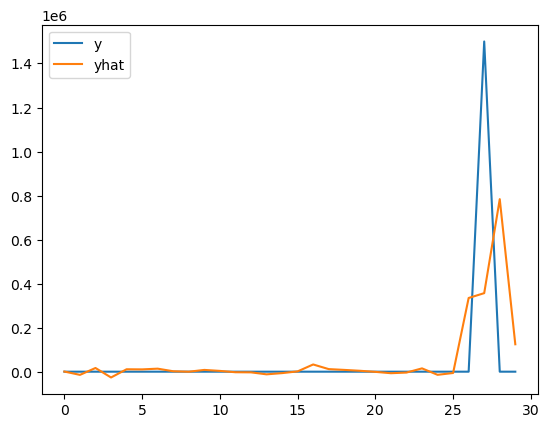

In [240]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Set parameters
timesteps = 35  # number of input steps
n_forecast_days = 30  # number of days to predict
data_length_train = len(df_masuk_train)  # length of training signal

# Create dataset for training
X_train = []
y_train = []

# Create input-output sequence for training
for i in range(data_length_train - timesteps - n_forecast_days + 1):
    X_train.append(df_masuk_train['y'].iloc[i:i + timesteps].values)
    y_train.append(df_masuk_train['y'].iloc[i + timesteps:i + timesteps + n_forecast_days].values)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

# Train MLP model
model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', 
                     max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train_scaled)

# Make predictions for 30 days ahead
last_input = df_masuk_train['y'].iloc[-timesteps:].values.reshape(1, -1)
last_input_scaled = scaler_X.transform(last_input)
y_pred_scaled = []

for _ in range(n_forecast_days):
    pred_scaled = model.predict(last_input_scaled)[0]
    y_pred_scaled.append(pred_scaled[0])
    last_input_scaled = np.roll(last_input_scaled, -1)
    last_input_scaled[0, -1] = pred_scaled[0]

# Inverse transform the predictions
y_pred = scaler_y.inverse_transform(np.array(y_pred_scaled).reshape(-1, n_forecast_days))[0]

# Display results
df_masuk_test['yhat'] = y_pred

df_masuk_test.plot()
print(mean_squared_error(df_masuk_test["y"], df_masuk_test["yhat"]))


### Pengeluaran

1999049579.6760125


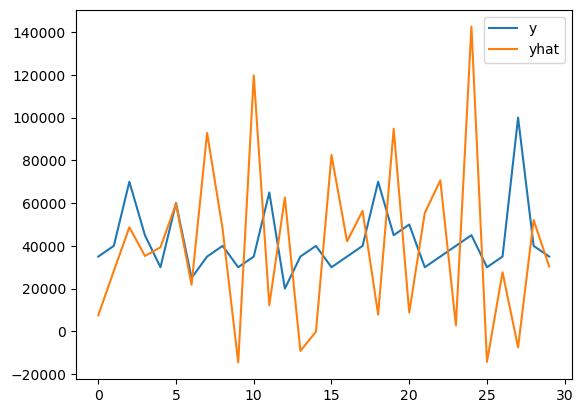

In [242]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# Assume df_luar_train is your DataFrame
# df_luar_train = pd.DataFrame({'y': np.random.rand(170)})  # Example DataFrame

# Set parameters
timesteps = 14  # number of input steps
n_forecast_days = 30  # number of days to predict
data_length_train = len(df_luar_train)  # length of training signal

# Create dataset for training
X_train = []
y_train = []

# Create input-output sequence for training
for i in range(data_length_train - timesteps - n_forecast_days + 1):
    X_train.append(df_luar_train['y'].iloc[i:i + timesteps].values)
    y_train.append(df_luar_train['y'].iloc[i + timesteps:i + timesteps + n_forecast_days].values)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

# Train MLP model
model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', 
                     max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train_scaled)

# Make predictions for 30 days ahead
last_input = df_luar_train['y'].iloc[-timesteps:].values.reshape(1, -1)
last_input_scaled = scaler_X.transform(last_input)
y_pred_scaled = []

for _ in range(n_forecast_days):
    pred_scaled = model.predict(last_input_scaled)[0]
    y_pred_scaled.append(pred_scaled[0])
    last_input_scaled = np.roll(last_input_scaled, -1)
    last_input_scaled[0, -1] = pred_scaled[0]

# Inverse transform the predictions
y_pred = scaler_y.inverse_transform(np.array(y_pred_scaled).reshape(-1, n_forecast_days))[0]

# Display results
df_luar_test['yhat'] = y_pred

df_luar_test.plot()
print(mean_squared_error(df_luar_test["y"], df_luar_test["yhat"]))

In [243]:
saldo_awal = 3855000
saldo_akhir_test = 4090000

temp1 = np.array(df_masuk_test["yhat"])
temp2 = np.array(df_luar_test["yhat"])

print(f"Saldo Awal anda adalah {saldo_awal}, dengan saldo akhir (true) adalah {saldo_akhir_test}")
for i in range(len(temp1)):
    saldo_awal = saldo_awal + temp1[i] - temp2[i]

print(f"saldo akhir prediksi anda adalah {saldo_awal}, dengan error sebesar {abs(saldo_akhir_test - saldo_awal)}")

Saldo Awal anda adalah 3855000, dengan saldo akhir (true) adalah 4090000
saldo akhir prediksi anda adalah 4293080.352126074, dengan error sebesar 203080.35212607402


In [244]:
nama_metode.append("MLP Sklearn")
saldo_akhir.append(round(saldo_awal))
error.append(round(abs(saldo_akhir_test - saldo_awal)))

## MLP Keras

### Pemasukan

In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# Set parameters
timesteps = 35  # number of input steps
n_forecast_days = 30  # number of days to predict
data_length_train = len(df_masuk_train)  # length of training signal

# Create dataset for training
X_train = []
y_train = []

# Create input-output sequence for training
for i in range(data_length_train - timesteps - n_forecast_days + 1):
    X_train.append(df_masuk_train['y'].iloc[i:i + timesteps].values)
    y_train.append(df_masuk_train['y'].iloc[i + timesteps:i + timesteps + n_forecast_days].values)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

# Build the Keras MLP model
model = Sequential([
    Dense(75, activation='relu', input_shape=(timesteps,)),
    Dense(75, activation='relu'),
    Dense(75, activation='relu'),
    Dense(n_forecast_days)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Make predictions for 30 days ahead
last_input = df_masuk_train['y'].iloc[-timesteps:].values.reshape(1, -1)
last_input_scaled = scaler_X.transform(last_input)
y_pred_scaled = []

for _ in range(n_forecast_days):
    pred_scaled = model.predict(last_input_scaled)
    y_pred_scaled.append(pred_scaled[0])
    last_input_scaled = np.roll(last_input_scaled, -1, axis=1)
    last_input_scaled[0, -1] = pred_scaled[0, 0]

# Inverse transform the predictions
y_pred = scaler_y.inverse_transform(np.array(y_pred_scaled))[0]

# Display the predicted values (if required)
df_masuk_test['yhat'] = y_pred

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - loss: 1.0685 - val_loss: 0.9869
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 1.0216 - val_loss: 0.9709
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.9866 - val_loss: 0.9642
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.9558 - val_loss: 0.9622
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.9558 - val_loss: 0.9635
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.9486 - val_loss: 0.9651
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.9210 - val_loss: 0.9674
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.9086 - val_loss: 0.9708
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.8929 - val_loss: 0.9752
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.8771 - val_loss: 0.9800
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - loss: 0.8607 - val_loss: 0.9863
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.8639 - v

1999049579.6760125


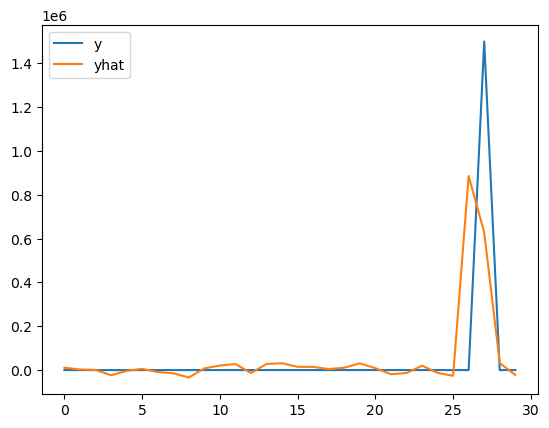

In [248]:
# Plotting results (if required)
df_masuk_test.plot()

print(mean_squared_error(df_luar_test["y"], df_luar_test["yhat"]))

### Pengeluaran

In [250]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# Assume df_luar_train is your DataFrame
# df_luar_train = pd.DataFrame({'y': np.random.rand(170)})  # Example DataFrame

# Set parameters
timesteps = 14  # number of input steps
n_forecast_days = 30  # number of days to predict
data_length_train = len(df_luar_train)  # length of training signal

# Create dataset for training
X_train = []
y_train = []

# Create input-output sequence for training
for i in range(data_length_train - timesteps - n_forecast_days + 1):
    X_train.append(df_luar_train['y'].iloc[i:i + timesteps].values)
    y_train.append(df_luar_train['y'].iloc[i + timesteps:i + timesteps + n_forecast_days].values)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

# Build the Keras MLP model
model = Sequential([
    Dense(75, activation='relu', input_shape=(timesteps,)),
    Dense(75, activation='relu'),
    Dense(75, activation='relu'),
    Dense(n_forecast_days)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Make predictions for 30 days ahead
last_input = df_luar_train['y'].iloc[-timesteps:].values.reshape(1, -1)
last_input_scaled = scaler_X.transform(last_input)
y_pred_scaled = []

for _ in range(n_forecast_days):
    pred_scaled = model.predict(last_input_scaled)
    y_pred_scaled.append(pred_scaled[0])
    last_input_scaled = np.roll(last_input_scaled, -1, axis=1)
    last_input_scaled[0, -1] = pred_scaled[0, 0]

# Inverse transform the predictions
y_pred = scaler_y.inverse_transform(np.array(y_pred_scaled))[0]

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 276ms/step - loss: 1.0585 - val_loss: 0.9347
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.0341 - val_loss: 0.9307
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.0241 - val_loss: 0.9298
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.0074 - val_loss: 0.9297
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.9882 - val_loss: 0.9299
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.9796 - val_loss: 0.9304
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.9743 - val_loss: 0.9311
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.9594 - val_loss: 0.9317
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.9512 - val_loss: 0.9327
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.9339 - val_loss: 0.9339
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.9391 - val_loss: 0.9358
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.9242 - val_l

317289445.36104417


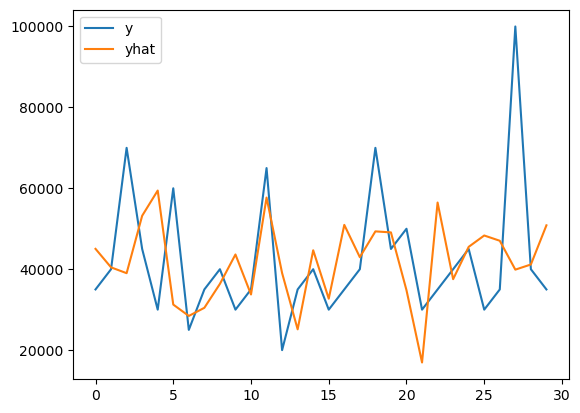

In [251]:
# Display results
df_luar_test['yhat'] = y_pred

df_luar_test.plot()
print(mean_squared_error(df_luar_test["y"], df_luar_test["yhat"]))

In [252]:
saldo_awal = 3855000
saldo_akhir_test = 4090000

temp1 = np.array(df_masuk_test["yhat"])
temp2 = np.array(df_luar_test["yhat"])

print(f"Saldo Awal anda adalah {saldo_awal}, dengan saldo akhir (true) adalah {saldo_akhir_test}")
for i in range(len(temp1)):
    saldo_awal = saldo_awal + temp1[i] - temp2[i]

print(f"saldo akhir prediksi anda adalah {saldo_awal}, dengan error sebesar {abs(saldo_akhir_test - saldo_awal)}")

Saldo Awal anda adalah 3855000, dengan saldo akhir (true) adalah 4090000
saldo akhir prediksi anda adalah 4196449.944641113, dengan error sebesar 106449.94464111328


In [253]:
nama_metode.append("MLP Keras")
saldo_akhir.append(round(saldo_awal))
error.append(round(abs(saldo_akhir_test - saldo_awal)))

## XGBoost

### Pemasukan

Predictions for the next 30 days: [6.8166484e+03 6.8166484e+03 6.8166484e+03 6.8166484e+03 6.8166484e+03
 6.8166484e+03 6.8166484e+03 6.8166484e+03 6.8166484e+03 6.8166484e+03
 6.8166484e+03 6.8166484e+03 6.8166484e+03 6.8166484e+03 6.8166484e+03
 5.0307266e+03 3.7777734e+03 7.5782237e+00 7.5782237e+00 7.5782237e+00
 7.5782237e+00 7.5782237e+00 7.5782237e+00 4.1133800e+00 1.4805672e+00
 2.8994880e+00 3.7487038e+05 3.7485281e+05 7.4983269e+05 2.3088945e+03]
65649165414.06749


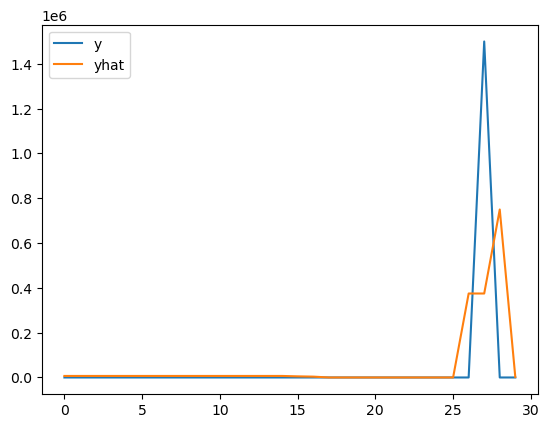

In [256]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Set parameters
timesteps = 14  # number of input steps
n_forecast_days = 30  # number of days to predict
data_length_train = len(df_masuk_train)  # length of training signal

# Create dataset for training
X_train = []
y_train = []

# Create input-output sequence for training
for i in range(data_length_train - timesteps - n_forecast_days + 1):
    X_train.append(df_masuk_train['y'].iloc[i:i + timesteps].values)
    y_train.append(df_masuk_train['y'].iloc[i + timesteps:i + timesteps + n_forecast_days].values)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

# Train XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train_scaled, y_train_scaled)

# Make predictions for 30 days ahead
last_input = df_masuk_train['y'].iloc[-timesteps:].values.reshape(1, -1)
last_input_scaled = scaler_X.transform(last_input)
y_pred_scaled = []

for _ in range(n_forecast_days):
    pred_scaled = model.predict(last_input_scaled).reshape(1, -1)
    y_pred_scaled.append(pred_scaled[0])
    last_input_scaled = np.roll(last_input_scaled, -1)
    last_input_scaled[0, -1] = pred_scaled[0, 0]

# Inverse transform the predictions
y_pred = scaler_y.inverse_transform(np.array(y_pred_scaled))[0]

# Display results
print("Predictions for the next 30 days:", y_pred)

# Plot prediction results
df_masuk_test['yhat'] = y_pred

df_masuk_test.plot()
print(mean_squared_error(df_masuk_test["y"], df_masuk_test["yhat"]))

### Pengeluaran

Predictions for the next 30 days: [32359.1   32336.516 39287.17  78617.79  32547.959 30893.05  57318.977
 25695.18  35109.08  43316.81  34104.715 41711.043 53111.754 61984.594
 37832.266 42373.293 39184.93  35172.336 50140.355 44789.996 43646.113
 47020.26  39539.805 34618.086 48144.746 37579.586 39956.645 48751.88
 94683.08  26732.031]
448083689.2897611


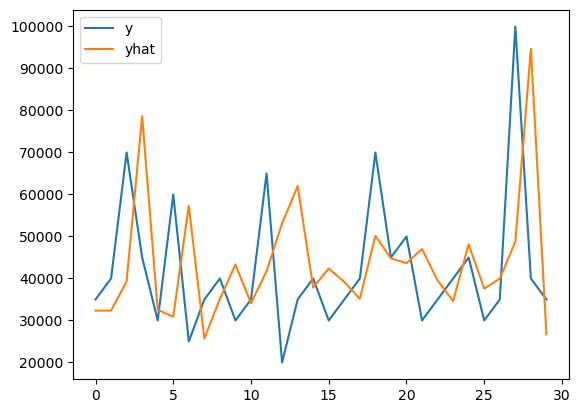

In [258]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

# Assume df_luar_train is your DataFrame
# df_luar_train = pd.DataFrame({'y': np.random.rand(170)})  # Example DataFrame

# Set parameters
timesteps = 14  # number of input steps
n_forecast_days = 30  # number of days to predict
data_length_train = len(df_luar_train)  # length of training signal

# Create dataset for training
X_train = []
y_train = []

# Create input-output sequence for training
for i in range(data_length_train - timesteps - n_forecast_days + 1):
    X_train.append(df_luar_train['y'].iloc[i:i + timesteps].values)
    y_train.append(df_luar_train['y'].iloc[i + timesteps:i + timesteps + n_forecast_days].values)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

# Train XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train_scaled, y_train_scaled)

# Make predictions for 30 days ahead
last_input = df_luar_train['y'].iloc[-timesteps:].values.reshape(1, -1)
last_input_scaled = scaler_X.transform(last_input)
y_pred_scaled = []

for _ in range(n_forecast_days):
    pred_scaled = model.predict(last_input_scaled).reshape(1, -1)
    y_pred_scaled.append(pred_scaled[0])
    last_input_scaled = np.roll(last_input_scaled, -1)
    last_input_scaled[0, -1] = pred_scaled[0, 0]

# Inverse transform the predictions
y_pred = scaler_y.inverse_transform(np.array(y_pred_scaled))[0]

# Display results
print("Predictions for the next 30 days:", y_pred)

# Plot prediction results
df_luar_test['yhat'] = y_pred

df_luar_test.plot()
print(mean_squared_error(df_luar_test["y"], df_luar_test["yhat"]))

In [259]:
saldo_awal = 3855000
saldo_akhir_test = 4090000

temp1 = np.array(df_masuk_test["yhat"])
temp2 = np.array(df_luar_test["yhat"])

print(f"Saldo Awal anda adalah {saldo_awal}, dengan saldo akhir (true) adalah {saldo_akhir_test}")
for i in range(len(temp1)):
    saldo_awal = saldo_awal + temp1[i] - temp2[i]

print(f"saldo akhir prediksi anda adalah {saldo_awal}, dengan error sebesar {abs(saldo_akhir_test - saldo_awal)}")

Saldo Awal anda adalah 3855000, dengan saldo akhir (true) adalah 4090000
saldo akhir prediksi anda adalah 4159417.818246126, dengan error sebesar 69417.81824612617


In [260]:
nama_metode.append("XGBoost")
saldo_akhir.append(round(saldo_awal))
error.append(round(abs(saldo_akhir_test - saldo_awal)))

## Arima

### Pemasukan

ARIMA(0, 0, 0) RMSE=258190.502
ARIMA(0, 0, 1) RMSE=257888.124
ARIMA(0, 0, 2) RMSE=257589.900
ARIMA(0, 0, 3) RMSE=257470.897
ARIMA(0, 1, 0) RMSE=452267.017
ARIMA(0, 1, 1) RMSE=258397.442
ARIMA(0, 1, 2) RMSE=257870.938
ARIMA(0, 1, 3) RMSE=257537.979
ARIMA(0, 2, 0) RMSE=866025.404
ARIMA(0, 2, 1) RMSE=454666.100
ARIMA(0, 2, 2) RMSE=262110.666
ARIMA(0, 2, 3) RMSE=260908.422
ARIMA(1, 0, 0) RMSE=257905.153
ARIMA(1, 0, 1) RMSE=252720.565
ARIMA(1, 0, 2) RMSE=253320.766
ARIMA(1, 0, 3) RMSE=252663.609
ARIMA(1, 1, 0) RMSE=378948.543
ARIMA(1, 1, 1) RMSE=258110.440
ARIMA(1, 1, 2) RMSE=256646.960
ARIMA(1, 1, 3) RMSE=256352.174
ARIMA(1, 2, 0) RMSE=606815.737
ARIMA(1, 2, 1) RMSE=381739.659
ARIMA(1, 2, 2) RMSE=261337.640
ARIMA(1, 2, 3) RMSE=259614.819
ARIMA(2, 0, 0) RMSE=257585.045
ARIMA(2, 0, 1) RMSE=252820.676
ARIMA(2, 0, 2) RMSE=250188.802
ARIMA(2, 0, 3) RMSE=247691.740
ARIMA(2, 1, 0) RMSE=332722.792
ARIMA(2, 1, 1) RMSE=257791.172
ARIMA(2, 1, 2) RMSE=256384.102
ARIMA(2, 1, 3) RMSE=259801.721
ARIMA(2,

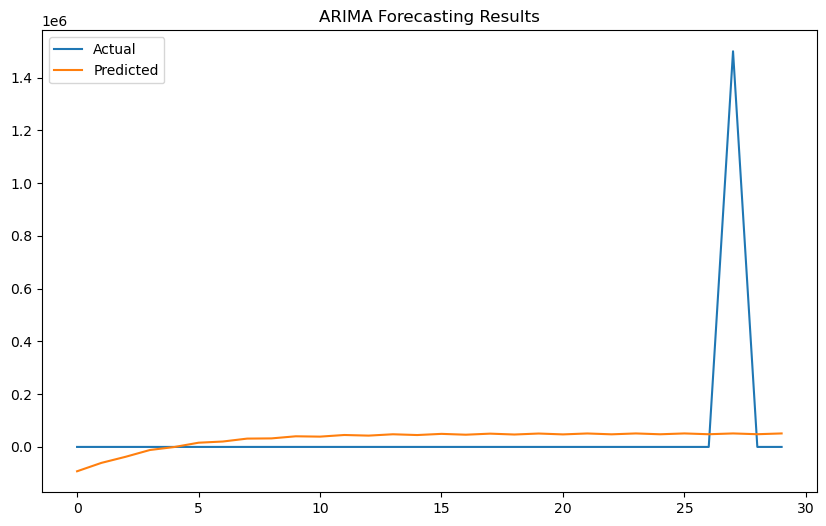

In [263]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from itertools import product

# Function to evaluate ARIMA model
def evaluate_arima_model(X, arima_order):
    # Prepare training dataset
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # Make predictions
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

# Function to perform grid search for ARIMA parameters
def grid_search_arima(X, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p, d, q in product(p_values, d_values, q_values):
        order = (p, d, q)
        try:
            rmse = evaluate_arima_model(X, order)
            if rmse < best_score:
                best_score, best_cfg = rmse, order
            print(f'ARIMA{order} RMSE={rmse:.3f}')
        except:
            continue
    print(f'Best ARIMA{best_cfg} RMSE={best_score:.3f}')
    return best_cfg

# Prepare the data
train_data = df_masuk_train['y'].values
test_data = df_masuk_test['y'].values

# Define the parameter grid
p_values = [0, 1, 2, 3]
d_values = [0, 1, 2]
q_values = [0, 1, 2, 3]

# Perform grid search
best_order = grid_search_arima(train_data, p_values, d_values, q_values)

# Fit the ARIMA model with the best parameters
model = ARIMA(train_data, order=best_order)
model_fit = model.fit()

# Make predictions
predictions1 = model_fit.forecast(steps=len(test_data))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, predictions1))
print(f'Test RMSE: {rmse:.3f}')

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(test_data, label='Actual')
plt.plot(predictions1, label='Predicted')
plt.legend()
plt.title('ARIMA Forecasting Results')
plt.show()

### Peneluaran

ARIMA(0, 0, 0) RMSE=15606.938
ARIMA(0, 0, 1) RMSE=16062.539
ARIMA(0, 0, 2) RMSE=15729.454
ARIMA(0, 0, 3) RMSE=15718.727
ARIMA(0, 1, 0) RMSE=25390.884
ARIMA(0, 1, 1) RMSE=15619.173
ARIMA(0, 1, 2) RMSE=15999.102
ARIMA(0, 1, 3) RMSE=15803.027
ARIMA(0, 2, 0) RMSE=46220.814
ARIMA(0, 2, 1) RMSE=25545.816
ARIMA(0, 2, 2) RMSE=18179.158
ARIMA(0, 2, 3) RMSE=16591.028
ARIMA(1, 0, 0) RMSE=16101.120
ARIMA(1, 0, 1) RMSE=15573.921
ARIMA(1, 0, 2) RMSE=15643.654
ARIMA(1, 0, 3) RMSE=15849.870
ARIMA(1, 1, 0) RMSE=22278.856
ARIMA(1, 1, 1) RMSE=16108.565
ARIMA(1, 1, 2) RMSE=15523.113
ARIMA(1, 1, 3) RMSE=15616.462
ARIMA(1, 2, 0) RMSE=34987.737
ARIMA(1, 2, 1) RMSE=22396.272
ARIMA(1, 2, 2) RMSE=18515.871
ARIMA(1, 2, 3) RMSE=17650.874
ARIMA(2, 0, 0) RMSE=15967.681
ARIMA(2, 0, 1) RMSE=15440.242
ARIMA(2, 0, 2) RMSE=15630.767
ARIMA(2, 0, 3) RMSE=15233.705
ARIMA(2, 1, 0) RMSE=19956.528
ARIMA(2, 1, 1) RMSE=15998.008
ARIMA(2, 1, 2) RMSE=15885.082
ARIMA(2, 1, 3) RMSE=16348.917
ARIMA(2, 2, 0) RMSE=29062.652
ARIMA(2, 2

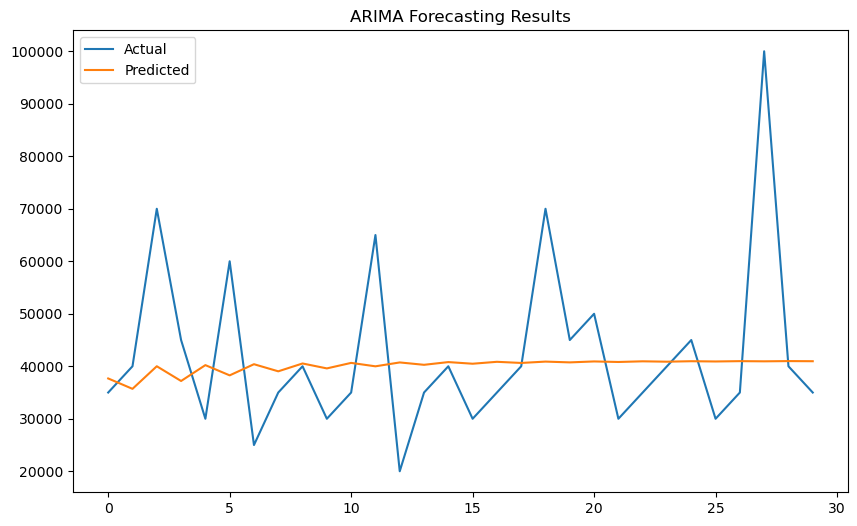

In [265]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from itertools import product

# Assume df_luar_train and df_luar_test are DataFrames with a 'y' column
# If the column name is different, adjust the code below

# Function to evaluate ARIMA model
def evaluate_arima_model(X, arima_order):
    # Prepare training dataset
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # Make predictions
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

# Function to perform grid search for ARIMA parameters
def grid_search_arima(X, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p, d, q in product(p_values, d_values, q_values):
        order = (p, d, q)
        try:
            rmse = evaluate_arima_model(X, order)
            if rmse < best_score:
                best_score, best_cfg = rmse, order
            print(f'ARIMA{order} RMSE={rmse:.3f}')
        except:
            continue
    print(f'Best ARIMA{best_cfg} RMSE={best_score:.3f}')
    return best_cfg

# Prepare the data
train_data = df_luar_train['y'].values
test_data = df_luar_test['y'].values

# Define the parameter grid
p_values = [0, 1, 2, 3]
d_values = [0, 1, 2]
q_values = [0, 1, 2, 3]

# Perform grid search
best_order = grid_search_arima(train_data, p_values, d_values, q_values)

# Fit the ARIMA model with the best parameters
model = ARIMA(train_data, order=best_order)
model_fit = model.fit()

# Make predictions
predictions2 = model_fit.forecast(steps=len(test_data))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, predictions2))
print(f'Test RMSE: {rmse:.3f}')

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(test_data, label='Actual')
plt.plot(predictions2, label='Predicted')
plt.legend()
plt.title('ARIMA Forecasting Results')
plt.show()

In [266]:
saldo_awal = 3855000
saldo_akhir_test = 4090000

temp1 = np.array(predictions1)
temp2 = np.array(predictions2)

print(f"Saldo Awal anda adalah {saldo_awal}, dengan saldo akhir (true) adalah {saldo_akhir_test}")
for i in range(len(temp1)):
    saldo_awal = saldo_awal + temp1[i] - temp2[i]

print(f"saldo akhir prediksi anda adalah {saldo_awal}, dengan error sebesar {abs(saldo_akhir_test - saldo_awal)}")

Saldo Awal anda adalah 3855000, dengan saldo akhir (true) adalah 4090000
saldo akhir prediksi anda adalah 3548731.6692701704, dengan error sebesar 541268.3307298296


In [267]:
nama_metode.append("Arima")
saldo_akhir.append(round(saldo_awal))
error.append(round(abs(saldo_akhir_test - saldo_awal)))

## Auto Arima

### Pemasukan

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4535.407, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4537.410, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4537.457, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4539.457, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4531.293, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4533.054, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4533.099, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4535.097, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.248 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  162
Model:                        SARIMAX   Log Likelihood               -2263.646
Date:                Sat, 12 Oct 2024   AIC                           4531.293
Time:                        20:20:0

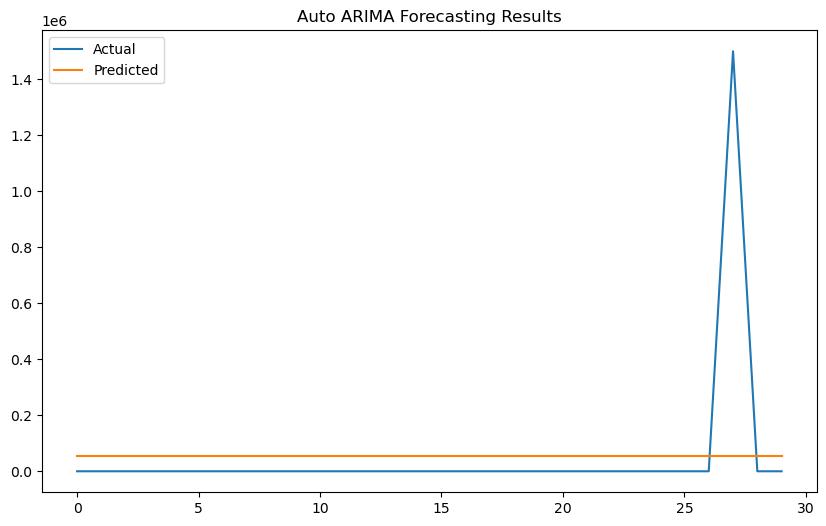

In [270]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

# Prepare the data
train_data = df_masuk_train['y'].values
test_data = df_masuk_test['y'].values

# Fit auto ARIMA model
model = auto_arima(train_data, 
                   start_p=0, start_q=0, 
                   max_p=3, max_q=3, 
                   m=1,  # Seasonality (for non-seasonal data, set m=1)
                   start_P=0, seasonal=False,  # Set seasonal=False for non-seasonal data
                   d=None,  # Let auto_arima determine the order of differencing
                   trace=True,  # Print model summary
                   error_action='ignore',  
                   suppress_warnings=True,  
                   stepwise=True)  # Stepwise search to reduce computation

# Summarize the model
print(model.summary())

# Make predictions
predictions1 = model.predict(n_periods=len(test_data))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, predictions1))
print(f'Test RMSE: {rmse:.3f}')

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(test_data, label='Actual')
plt.plot(predictions1, label='Predicted')
plt.legend()
plt.title('Auto ARIMA Forecasting Results')
plt.show()

### Pengeluaran

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3928.103, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3751.653, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3867.520, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3696.078, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=3670.366, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.58 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=3605.523, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3604.287, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3604.522, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3606.451, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3609.070, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=3607.410, Time=0.31 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 2.136 seconds
                               S

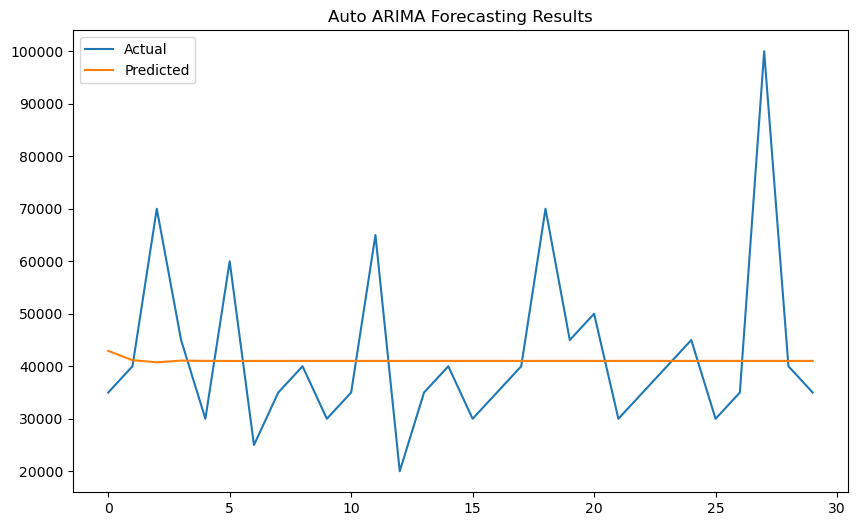

In [272]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

# Assume df_luar_train and df_luar_test are DataFrames with a 'y' column
# If the column name is different, adjust the code below

# Prepare the data
train_data = df_luar_train['y'].values
test_data = df_luar_test['y'].values

# Fit auto ARIMA model
model = auto_arima(train_data, 
                   start_p=0, start_q=0, 
                   max_p=3, max_q=3, 
                   m=1,  # Seasonality (for non-seasonal data, set m=1)
                   start_P=0, seasonal=False,  # Set seasonal=False for non-seasonal data
                   d=None,  # Let auto_arima determine the order of differencing
                   trace=True,  # Print model summary
                   error_action='ignore',  
                   suppress_warnings=True,  
                   stepwise=True)  # Stepwise search to reduce computation

# Summarize the model
print(model.summary())

# Make predictions
predictions2 = model.predict(n_periods=len(test_data))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, predictions2))
print(f'Test RMSE: {rmse:.3f}')

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(test_data, label='Actual')
plt.plot(predictions2, label='Predicted')
plt.legend()
plt.title('Auto ARIMA Forecasting Results')
plt.show()

In [273]:
saldo_awal = 3855000
saldo_akhir_test = 4090000

temp1 = np.array(predictions1)
temp2 = np.array(predictions2)

print(f"Saldo Awal anda adalah {saldo_awal}, dengan saldo akhir (true) adalah {saldo_akhir_test}")
for i in range(len(temp1)):
    saldo_awal = saldo_awal + temp1[i] - temp2[i]

print(f"saldo akhir prediksi anda adalah {saldo_awal}, dengan error sebesar {abs(saldo_akhir_test - saldo_awal)}")

Saldo Awal anda adalah 3855000, dengan saldo akhir (true) adalah 4090000
saldo akhir prediksi anda adalah 4289175.054684647, dengan error sebesar 199175.05468464736


In [274]:
nama_metode.append("Auto Arima")
saldo_akhir.append(round(saldo_awal))
error.append(round(abs(saldo_akhir_test - saldo_awal)))

## ETS

### Pemasukan

ETS(add,add,7) RMSE=260125.441
ETS(add,add,12) RMSE=317483.860
ETS(add,None,None) RMSE=396358.167
ETS(add,None,7) RMSE=396358.167
ETS(add,None,12) RMSE=396358.167
ETS(None,add,7) RMSE=257778.372
ETS(None,add,12) RMSE=307732.128
ETS(None,None,None) RMSE=269787.222
ETS(None,None,7) RMSE=269787.222
ETS(None,None,12) RMSE=269787.222
Best ETS(None, 'add', 7) RMSE=257778.372
Test RMSE: 257778.372


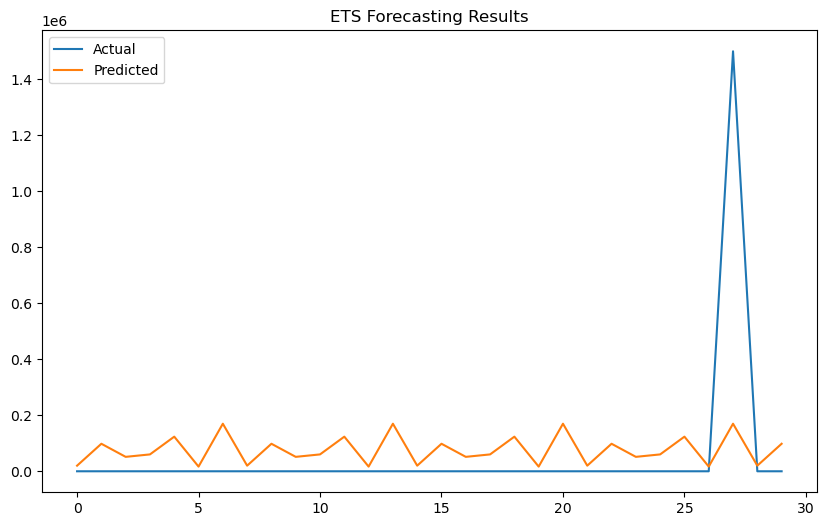

Future predictions: [ 20034.42288549  98276.58066206  51531.30735459  60247.85776215
 123626.71804178  16758.44982404 169881.9911887   20034.42288549
  98276.58066206  51531.30735459  60247.85776215 123626.71804178
  16758.44982404 169881.9911887   20034.42288549  98276.58066206
  51531.30735459  60247.85776215 123626.71804178  16758.44982404
 169881.9911887   20034.42288549  98276.58066206  51531.30735459
  60247.85776215 123626.71804178  16758.44982404 169881.9911887
  20034.42288549  98276.58066206]


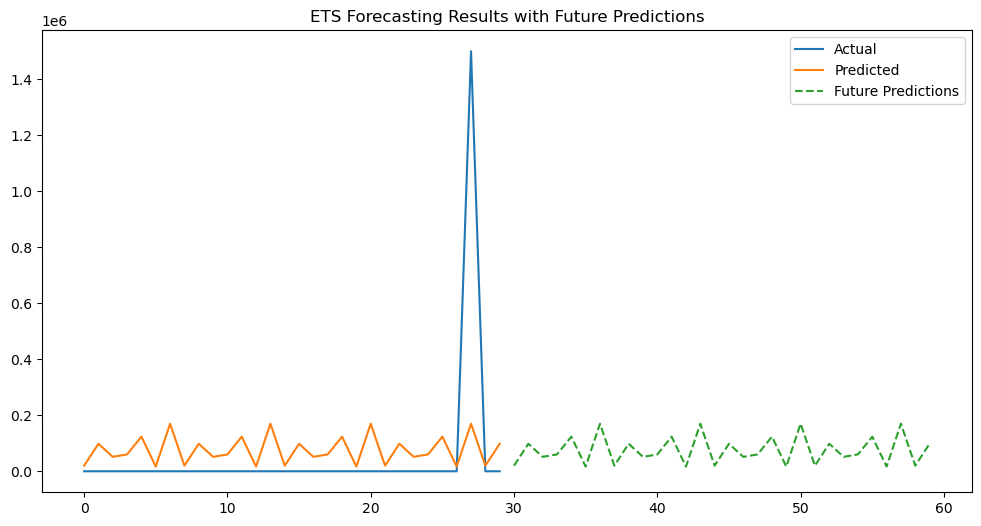

In [277]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from itertools import product

# Function to evaluate ETS model
def evaluate_ets_model(train, test, trend, seasonal, seasonal_periods):
    # Fit model
    model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
    model_fit = model.fit()
    
    # Make predictions
    predictions = model_fit.forecast(len(test))
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse, model_fit

# Function to perform grid search for ETS parameters
def grid_search_ets(train, test, trends, seasonals, seasonal_periods):
    best_score, best_cfg, best_model = float("inf"), None, None
    for t, s, sp in product(trends, seasonals, seasonal_periods):
        try:
            rmse, model = evaluate_ets_model(train, test, trend=t, seasonal=s, seasonal_periods=sp)
            if rmse < best_score:
                best_score, best_cfg, best_model = rmse, (t, s, sp), model
            print(f'ETS({t},{s},{sp}) RMSE={rmse:.3f}')
        except:
            continue
    print(f'Best ETS{best_cfg} RMSE={best_score:.3f}')
    return best_cfg, best_model

# Prepare the data
train_data = df_masuk_train['y'].values
test_data = df_masuk_test['y'].values

# Define the parameter grid
trends = ['add', 'mul', None]
seasonals = ['add', 'mul', None]
seasonal_periods = [None, 7, 12]  # Adjust based on your data frequency

# Perform grid search
best_params, best_model = grid_search_ets(train_data, test_data, trends, seasonals, seasonal_periods)

# Make predictions using the best model
predictions = best_model.forecast(len(test_data))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, predictions))
print(f'Test RMSE: {rmse:.3f}')

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(test_data, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title('ETS Forecasting Results')
plt.show()

# If you want to make future predictions
future_periods = 30  # Adjust as needed
future_predictions = best_model.forecast(future_periods)
print("Future predictions:", future_predictions)

# Plot including future predictions
plt.figure(figsize=(12, 6))
plt.plot(range(len(test_data)), test_data, label='Actual')
plt.plot(range(len(test_data)), predictions, label='Predicted')
plt.plot(range(len(test_data), len(test_data) + future_periods), future_predictions, label='Future Predictions', linestyle='--')
plt.legend()
plt.title('ETS Forecasting Results with Future Predictions')
plt.show()

### Pengeluaran

ETS(add,add,7) RMSE=16456.317
ETS(add,add,12) RMSE=18324.129
ETS(add,mul,7) RMSE=16639.617
ETS(add,mul,12) RMSE=18147.634
ETS(add,None,None) RMSE=16648.541
ETS(add,None,7) RMSE=16648.541
ETS(add,None,12) RMSE=16648.541
ETS(mul,add,7) RMSE=16345.181
ETS(mul,add,12) RMSE=17946.706
ETS(mul,mul,7) RMSE=16681.489
ETS(mul,mul,12) RMSE=18236.212
ETS(mul,None,None) RMSE=18331.936
ETS(mul,None,7) RMSE=18331.936
ETS(mul,None,12) RMSE=18331.936
ETS(None,add,7) RMSE=16385.163
ETS(None,add,12) RMSE=17279.738
ETS(None,mul,7) RMSE=16429.784
ETS(None,mul,12) RMSE=17973.920
ETS(None,None,None) RMSE=16111.155
ETS(None,None,7) RMSE=16111.155
ETS(None,None,12) RMSE=16111.155
Best ETS(None, None, None) RMSE=16111.155
Test RMSE: 16111.155


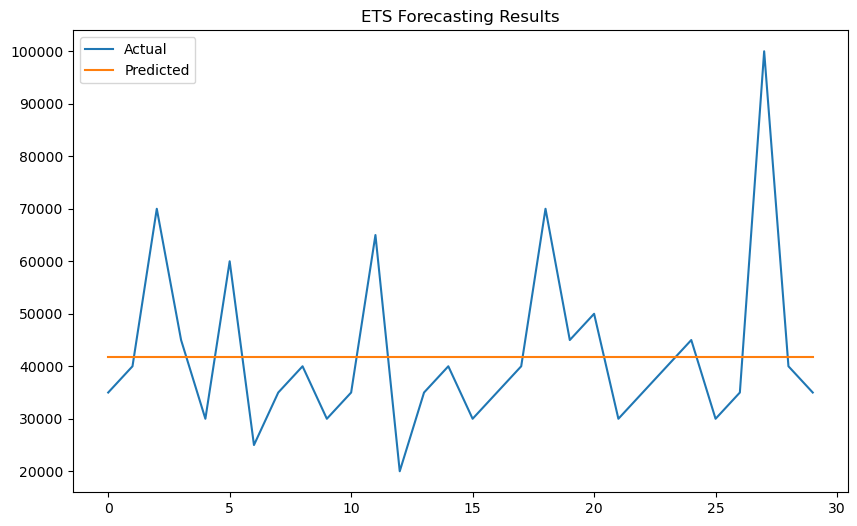

Future predictions: [41855.04839414 41855.04839414 41855.04839414 41855.04839414
 41855.04839414 41855.04839414 41855.04839414 41855.04839414
 41855.04839414 41855.04839414 41855.04839414 41855.04839414
 41855.04839414 41855.04839414 41855.04839414 41855.04839414
 41855.04839414 41855.04839414 41855.04839414 41855.04839414
 41855.04839414 41855.04839414 41855.04839414 41855.04839414
 41855.04839414 41855.04839414 41855.04839414 41855.04839414
 41855.04839414 41855.04839414]


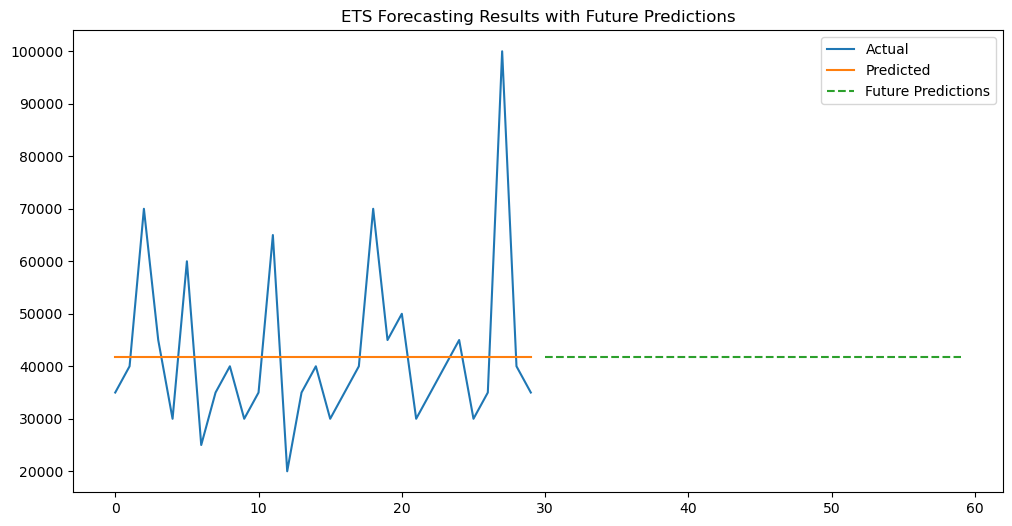

In [279]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from itertools import product

# Assume df_luar_train and df_luar_test are DataFrames with a 'y' column
# If the column name is different, adjust the code below

def evaluate_ets_model(train, test, trend, seasonal, seasonal_periods):
    # Fit model
    model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
    model_fit = model.fit()
    
    # Make predictions
    predictions = model_fit.forecast(len(test))
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse, model_fit

def grid_search_ets(train, test, trends, seasonals, seasonal_periods):
    best_score, best_cfg, best_model = float("inf"), None, None
    for t, s, sp in product(trends, seasonals, seasonal_periods):
        try:
            rmse, model = evaluate_ets_model(train, test, trend=t, seasonal=s, seasonal_periods=sp)
            if rmse < best_score:
                best_score, best_cfg, best_model = rmse, (t, s, sp), model
            print(f'ETS({t},{s},{sp}) RMSE={rmse:.3f}')
        except:
            continue
    print(f'Best ETS{best_cfg} RMSE={best_score:.3f}')
    return best_cfg, best_model

# Prepare the data
train_data = df_luar_train['y'].values
test_data = df_luar_test['y'].values

# Define the parameter grid
trends = ['add', 'mul', None]
seasonals = ['add', 'mul', None]
seasonal_periods = [None, 7, 12]  # Adjust based on your data frequency

# Perform grid search
best_params, best_model = grid_search_ets(train_data, test_data, trends, seasonals, seasonal_periods)

# Make predictions using the best model
predictions = best_model.forecast(len(test_data))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, predictions))
print(f'Test RMSE: {rmse:.3f}')

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(test_data, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title('ETS Forecasting Results')
plt.show()

# If you want to make future predictions
future_periods = 30  # Adjust as needed
future_predictions = best_model.forecast(future_periods)
print("Future predictions:", future_predictions)

# Plot including future predictions
plt.figure(figsize=(12, 6))
plt.plot(range(len(test_data)), test_data, label='Actual')
plt.plot(range(len(test_data)), predictions, label='Predicted')
plt.plot(range(len(test_data), len(test_data) + future_periods), future_predictions, label='Future Predictions', linestyle='--')
plt.legend()
plt.title('ETS Forecasting Results with Future Predictions')
plt.show()

# Keputusan pemakaian model

In [281]:
df_sum = pd.DataFrame({
    'Nama Metode' : nama_metode,
    'Saldo Akhir' : saldo_akhir,
    'Error' : error
})

df_sum

,Nama Metode,Saldo Akhir,Error
0,prophet,4604169,514169
1,LSTM,3989299,100701
2,Random Forest,4112200,22200
3,SVR,5550529,1460529
4,MLP Sklearn,4293080,203080
5,MLP Keras,4196450,106450
6,XGBoost,4159418,69418
7,Arima,3548732,541268
8,Auto Arima,4289175,199175
